# Imports

In [ ]:
!pip install -U scikit-activeml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iteration-utilities: filename=iteration_utilities-0.11.0-cp310-cp310-linux_x86_64.whl size=327916 sha256=9424241a39e2b0c05fa9c1f892d1f17bc35d1bb1a99f7650031ae7f8ac5a7290
  Stored in directory: /root/.cache/pip/wheels/2d/ab/c4/309aa5942beba1f36d6744acf619b7a314fca50f6a7ccce68c
Successfully built iteration-utilities
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: joblib
    Found existing installation: 

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier

from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

# Load and Prepare Data

In [ ]:
# Load the Breast Cancer dataset
data = load_iris()

# Convert to DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add target column to the DataFrame
df['target'] = data.target

In [ ]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


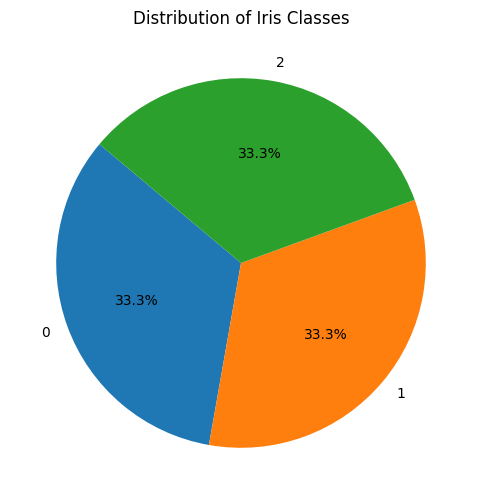

In [ ]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=df.target.unique(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Iris Classes')
plt.show()

# Entropy

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
# clf_entropy = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

clf_entropy = ParzenWindowClassifier(classes=np.unique(y_true), random_state=42)
# Initialise the query strategy.
qs_entropy = UncertaintySampling(method='entropy')

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_entropy.fit(X, y)

unqueried_score = clf_entropy.score(X,y_true)
print(unqueried_score)

0.2733333333333333


In [ ]:
performance_history_entropy = [unqueried_score]

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_entropy.fit(X, y)

  model_accuracy = clf_entropy.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_entropy.query(X=X, y=y, clf=clf_entropy)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_entropy.append(model_accuracy)

Query 1: The accuracy score is 0.2733333333333333.
Query 2: The accuracy score is 0.3333333333333333.
Query 3: The accuracy score is 0.5733333333333334.
Query 4: The accuracy score is 0.36.
Query 5: The accuracy score is 0.5733333333333334.
Query 6: The accuracy score is 0.5466666666666666.
Query 7: The accuracy score is 0.5933333333333334.
Query 8: The accuracy score is 0.5666666666666667.
Query 9: The accuracy score is 0.6133333333333333.
Query 10: The accuracy score is 0.5733333333333334.
Query 11: The accuracy score is 0.6333333333333333.
Query 12: The accuracy score is 0.5133333333333333.
Query 13: The accuracy score is 0.6266666666666667.
Query 14: The accuracy score is 0.6066666666666667.
Query 15: The accuracy score is 0.6266666666666667.
Query 16: The accuracy score is 0.62.
Query 17: The accuracy score is 0.6333333333333333.
Query 18: The accuracy score is 0.56.
Query 19: The accuracy score is 0.6533333333333333.
Query 20: The accuracy score is 0.5933333333333334.
Query 21: T

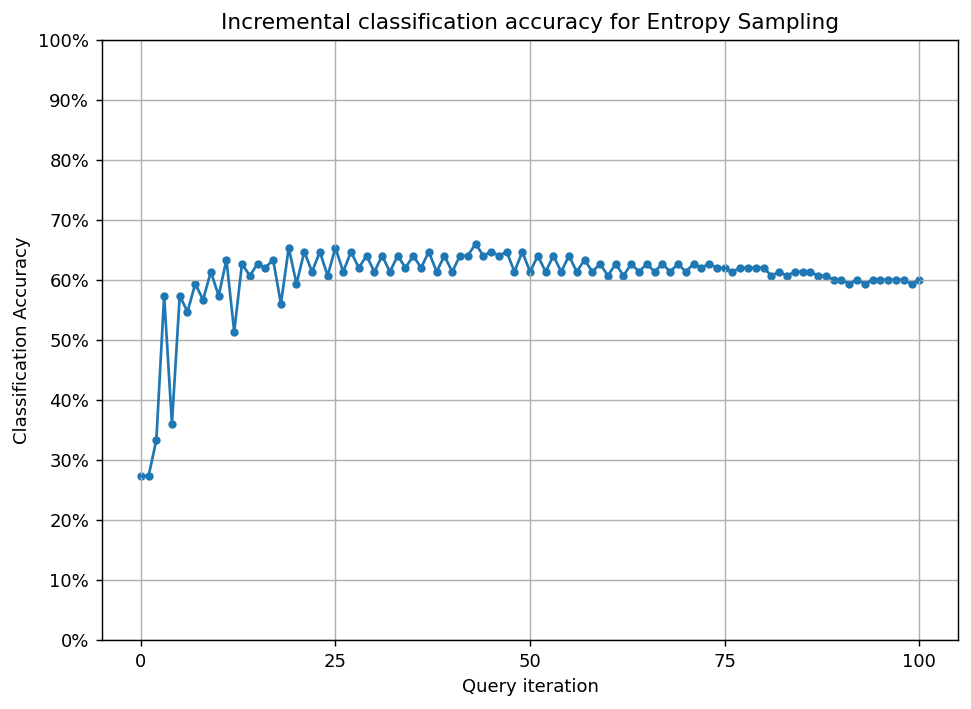

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_entropy)
ax.scatter(range(len(performance_history_entropy)), performance_history_entropy, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Entropy Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

# Margin Sampling

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
# clf_margin = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

clf_margin = ParzenWindowClassifier(classes=np.unique(y_true), random_state=42)
# Initialise the query strategy.
qs_margin = UncertaintySampling(method='margin_sampling')

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_margin.fit(X, y)

unqueried_score = clf_margin.score(X,y_true)
print(unqueried_score)

0.2733333333333333


In [ ]:
performance_history_margin = [unqueried_score]

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_margin.fit(X, y)

  model_accuracy = clf_margin.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_margin.query(X=X, y=y, clf=clf_margin)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_margin.append(model_accuracy)

Query 1: The accuracy score is 0.2733333333333333.
Query 2: The accuracy score is 0.3333333333333333.
Query 3: The accuracy score is 0.6666666666666666.
Query 4: The accuracy score is 0.8666666666666667.
Query 5: The accuracy score is 0.8666666666666667.
Query 6: The accuracy score is 0.9266666666666666.
Query 7: The accuracy score is 0.8866666666666667.
Query 8: The accuracy score is 0.9266666666666666.
Query 9: The accuracy score is 0.9.
Query 10: The accuracy score is 0.9333333333333333.
Query 11: The accuracy score is 0.9066666666666666.
Query 12: The accuracy score is 0.96.
Query 13: The accuracy score is 0.9133333333333333.
Query 14: The accuracy score is 0.96.
Query 15: The accuracy score is 0.88.
Query 16: The accuracy score is 0.8.
Query 17: The accuracy score is 0.94.
Query 18: The accuracy score is 0.9666666666666667.
Query 19: The accuracy score is 0.92.
Query 20: The accuracy score is 0.9733333333333334.
Query 21: The accuracy score is 0.9066666666666666.
Query 22: The acc

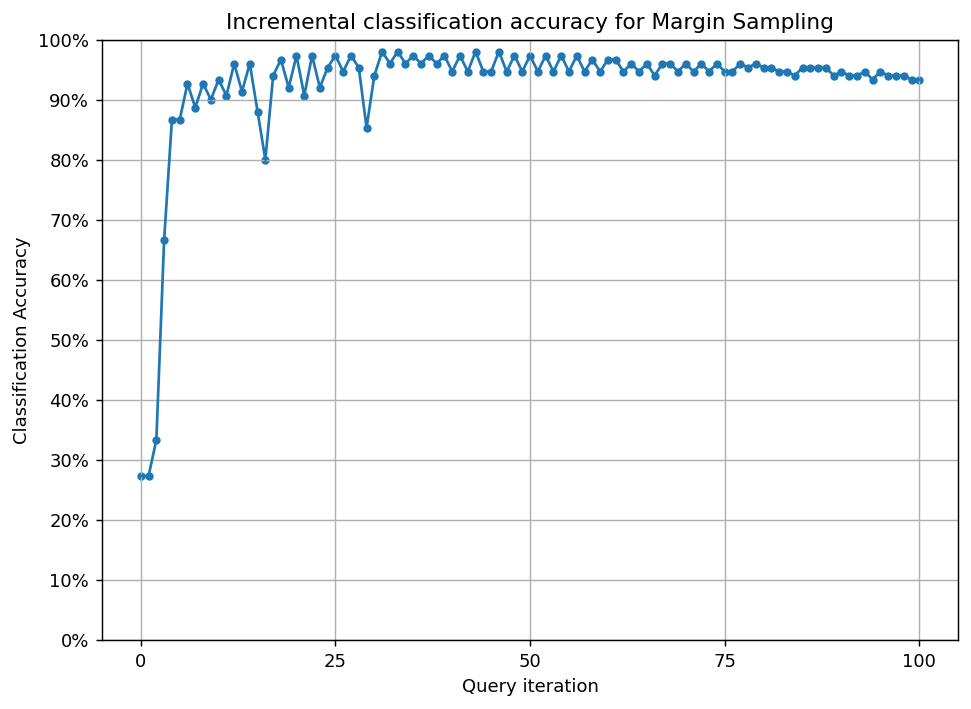

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_margin)
ax.scatter(range(len(performance_history_margin)), performance_history_margin, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Margin Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

# Query by Committee

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
clf_committee = SklearnClassifier(BaggingClassifier(ParzenWindowClassifier()), classes=np.unique(y_true))

# Initialise the query strategy.
qs_committee = QueryByCommittee(random_state=42)

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_committee.fit(X, y)

unqueried_score = clf_committee.score(X,y_true)
print(unqueried_score)

0.4066666666666667


In [ ]:
performance_history_committee = [unqueried_score]

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_committee.fit(X, y)

  model_accuracy = clf_committee.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_committee.query(X=X, y=y, ensemble=clf_committee)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_committee.append(model_accuracy)

Query 1: The accuracy score is 0.3333333333333333.
Query 2: The accuracy score is 0.3333333333333333.
Query 3: The accuracy score is 0.3333333333333333.
Query 4: The accuracy score is 0.64.
Query 5: The accuracy score is 0.8333333333333334.
Query 6: The accuracy score is 0.8933333333333333.
Query 7: The accuracy score is 0.8733333333333333.
Query 8: The accuracy score is 0.78.
Query 9: The accuracy score is 0.86.
Query 10: The accuracy score is 0.8733333333333333.
Query 11: The accuracy score is 0.6733333333333333.
Query 12: The accuracy score is 0.8.
Query 13: The accuracy score is 0.9266666666666666.
Query 14: The accuracy score is 0.9333333333333333.
Query 15: The accuracy score is 0.9266666666666666.
Query 16: The accuracy score is 0.9466666666666667.
Query 17: The accuracy score is 0.82.
Query 18: The accuracy score is 0.8666666666666667.
Query 19: The accuracy score is 0.9.
Query 20: The accuracy score is 0.92.
Query 21: The accuracy score is 0.8466666666666667.
Query 22: The acc

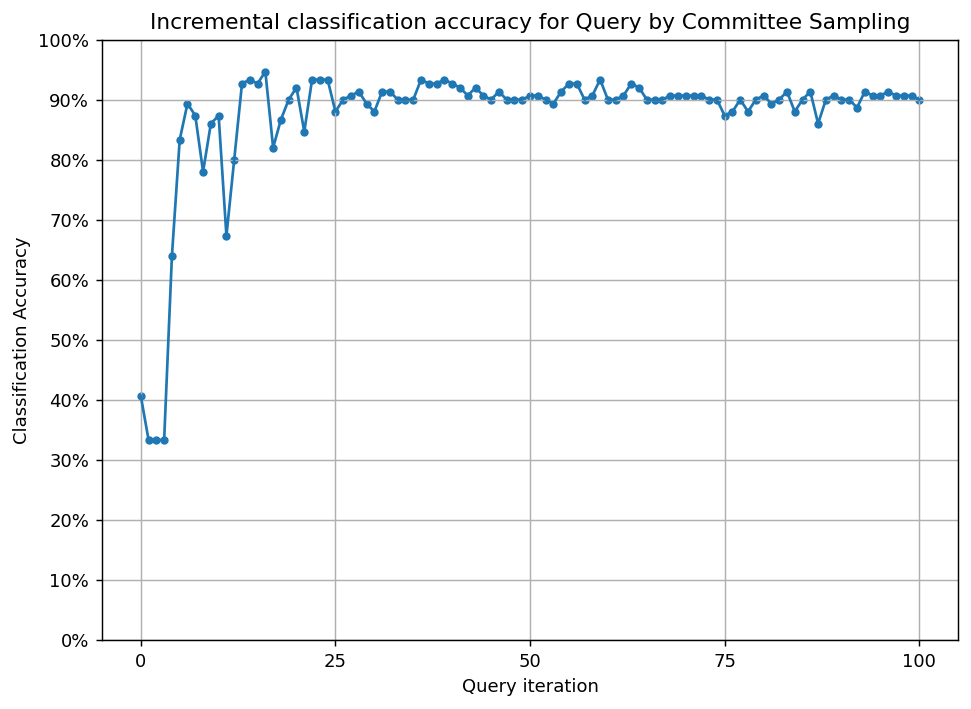

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_committee)
ax.scatter(range(len(performance_history_committee)), performance_history_committee, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Query by Committee Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()